In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import matplotlib as mpl
import pandas as pd
import matplotlib.patches as mpatches  # Import for manual legend entries

In [3]:
base_dir = './cleaned_data/'

# Define file paths
files = {
    'boundaries': [
        os.path.join(base_dir, 'boundaries.json')
    ],
    'buildings': [
        os.path.join(base_dir, 'Bures-sur-Yvette, France_buildings.pkl'),
        os.path.join(base_dir, 'Massy, Essonne_buildings.pkl'),
        os.path.join(base_dir, 'Palaiseau, France_buildings.pkl'),
        os.path.join(base_dir, 'Orsay, France_buildings.pkl'),
        os.path.join(base_dir, 'Gif-sur-Yvette, France_buildings.pkl')
    ],
    'student_housing': [
        os.path.join(base_dir, 'Bures-sur-Yvette, France_student_housing.pkl'),
        os.path.join(base_dir, 'Orsay, France_student_housing.pkl'),
        os.path.join(base_dir, 'Palaiseau, France_student_housing.pkl'),
        os.path.join(base_dir, 'Massy, Essonne_student_housing.pkl'),
        os.path.join(base_dir, 'Gif-sur-Yvette, France_student_housing.pkl')
    ]
}

# Load data
osm_data = {category: [load_pickle_data(f) for f in file_list] for category, file_list in files.items()}

/tmp/ipykernel_4435/2057560359.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  clipped_isochrones = gpd.overlay(selected_isochrones, boundaries, how='intersection')


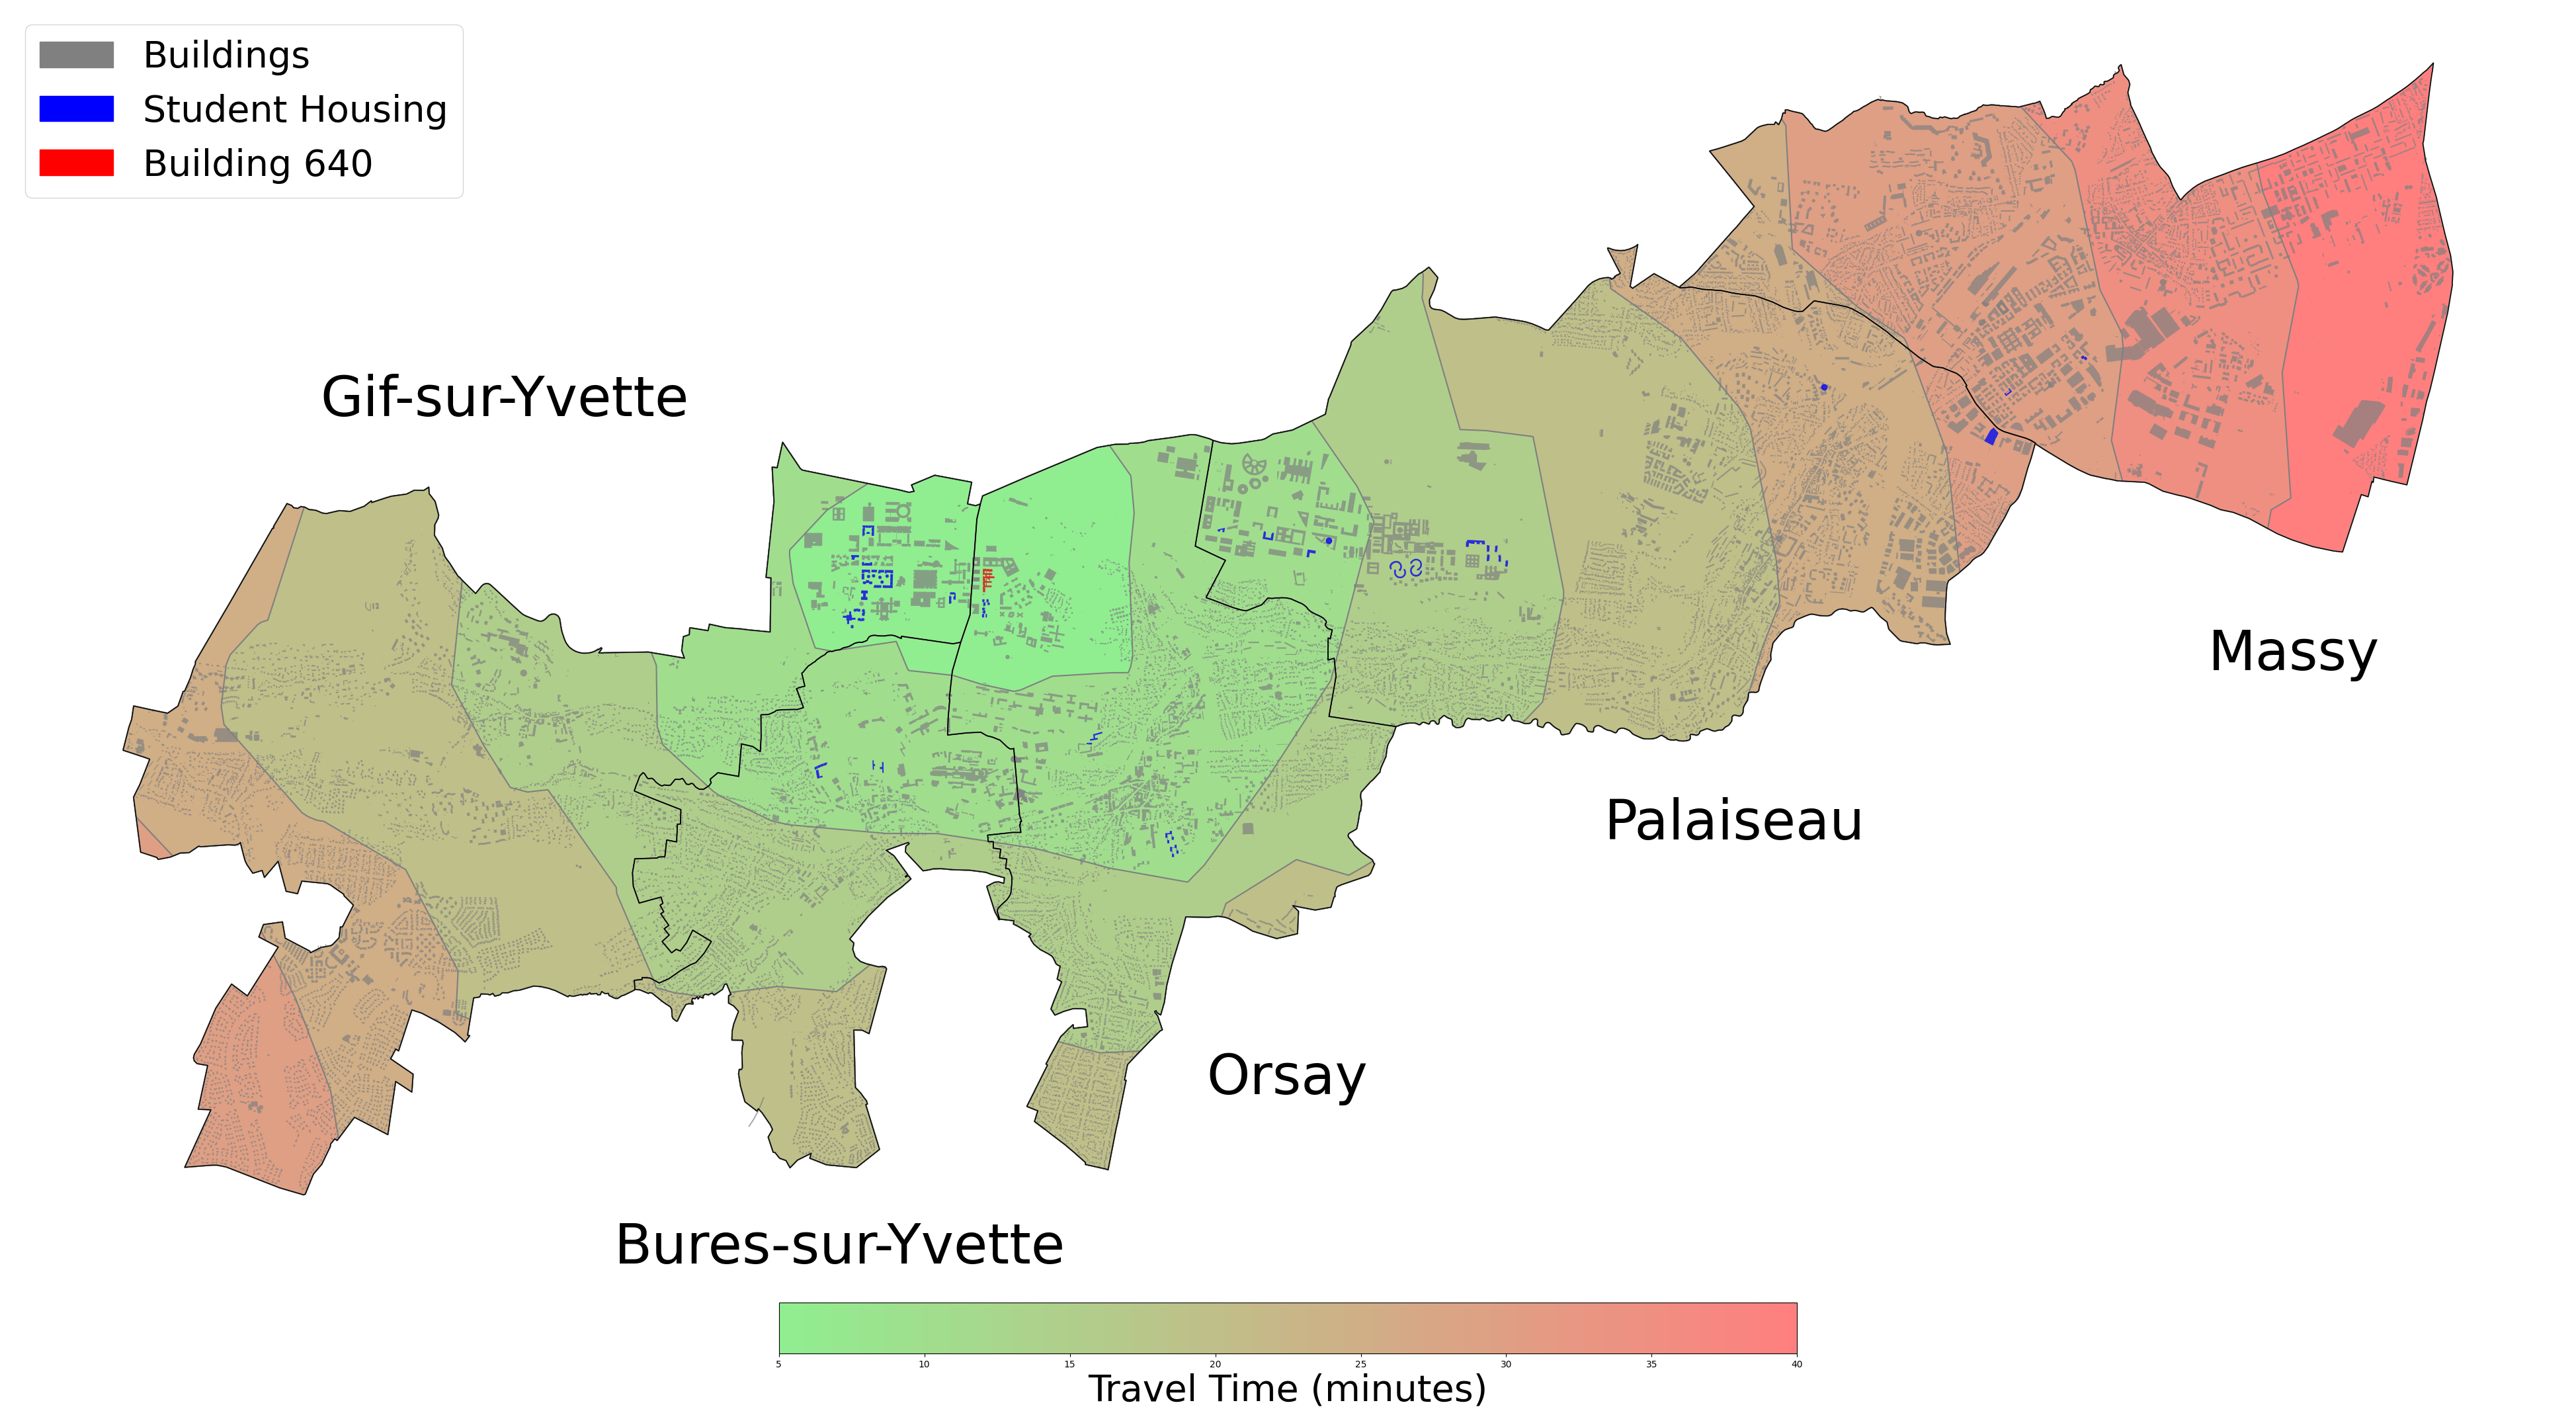

In [9]:
# MAP WITH LEGEND
iso_gdf = load_pickle_data('./cleaned_data/isochrone_data.pkl')
boundaries = gpd.GeoDataFrame(pd.concat(osm_data['boundaries'], ignore_index=True))
buildings = gpd.GeoDataFrame(pd.concat(osm_data['buildings'], ignore_index=True))
student_housing = gpd.GeoDataFrame(pd.concat(osm_data['student_housing'], ignore_index=True))
building_640 = buildings[buildings['ref'] == '640']

# Filter isochrones for specified times
time_intervals = [5, 10, 15, 20, 25, 30, 35, 40]
selected_isochrones = iso_gdf[iso_gdf['time min'].isin(time_intervals)]

# Clip isochrones by the town boundaries
clipped_isochrones = gpd.overlay(selected_isochrones, boundaries, how='intersection')

# # Define a colormap from green to red
# cmap = mpl.cm.RdYlGn_r  # Reverse RdYlGn colormap (Green to Red)
green_to_red = mpl.colors.LinearSegmentedColormap.from_list(
    "LightGreenLightRed", ["#90EE90", "#FF7F7F"]  # Light green to light red
)
cmap = green_to_red

# Normalize the color scale based on the time range
norm = mpl.colors.Normalize(vmin=clipped_isochrones['time min'].min(), vmax=clipped_isochrones['time min'].max())

fig, ax = plt.subplots(figsize=(50, 50))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Plot the clipped isochrones with color based on 'time min'
iso_plot = clipped_isochrones.plot(ax=ax, column='time min', cmap=cmap, linewidth=1.5, legend=False, edgecolor='gray',
                                   norm=norm, alpha=1)

# Add colorbar legend for travel time
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.02)
cbar.set_label("Travel Time (minutes)", fontsize=40)

# Plot different building categories
buildings.plot(ax=ax, color='gray', alpha=0.7)
student_housing.plot(ax=ax, color='blue', alpha=0.7)
building_640.plot(ax=ax, color='red', alpha=0.7)

# Plot the boundaries on top
boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Add town labels
ax.text(2.29, 48.705, 'Massy', fontsize=60, ha='center')
ax.text(2.24, 48.695, 'Palaiseau', fontsize=60, ha='center')
ax.text(2.20, 48.68, 'Orsay', fontsize=60, ha='center')
ax.text(2.16, 48.67, 'Bures-sur-Yvette', fontsize=60, ha='center')
ax.text(2.13, 48.72, 'Gif-sur-Yvette', fontsize=60, ha='center')

# Create custom legend handles
legend_patches = [
    mpatches.Patch(color='gray', label='Buildings'),
    mpatches.Patch(color='blue', label='Student Housing'),
    mpatches.Patch(color='red', label='Building 640')
]

ax.legend(handles=legend_patches, loc='upper left', fontsize=40)

# Save the figure
fig.savefig('map.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.show()
